Binary 2/6 C)

mRNA localization using binary classification (cytoplasm/mitochondria) (part 1/2): basic model with: <br> 
<br>
a) Method 6: no feature selection and class weights accounted for <br>
b) Method 7: with feature importance-based feature selection (SHAP), w/ threshold > 0  and class weights accounted for<br>

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report


In [3]:
#data initialization

#Cytoplasm (label = 0)
CP_train = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_train_CSV.csv")
CP_test = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_test_CSV.csv")

#Mitochondria (label = 2)
MT_train = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_train_CSV.csv")
MT_test = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_test_CSV.csv")

print("CP TRAIN, TEST SHAPE:", CP_train.shape, ",", CP_test.shape)
print("MT TRAIN, TEST SHAPE:", MT_train.shape, ",", MT_test.shape)

CP TRAIN, TEST SHAPE: (824, 1026) , (206, 1026)
MT TRAIN, TEST SHAPE: (280, 1026) , (70, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:


#Group 2: CP + MT

frames_CM_tra = [CP_train, MT_train]
frames_CM_tes = [CP_test, MT_test]

CP_MT_train = pd.concat(frames_CM_tra)
CP_MT_test = pd.concat(frames_CM_tes)


In [6]:

print("CP + MT TRAIN, TEST SHAPE:", CP_MT_train.shape, ",", CP_MT_test.shape)


CP + MT TRAIN, TEST SHAPE: (1104, 1026) , (276, 1026)


In [7]:
CP_MT_test.head(209)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_16986#79230|0|testing,0,0.008836,0.002834,0.002334,0.003168,0.001667,0.003168,0.000000,0.002001,...,0.000834,0.001834,0.001167,0.000500,0.001667,0.001834,0.001667,0.002501,0.002001,0.011504
1,mRNALoc_8139#3082|0|testing,0,0.009503,0.002501,0.003168,0.006002,0.003001,0.000834,0.000167,0.002668,...,0.000167,0.003168,0.001667,0.001334,0.001667,0.003501,0.005835,0.001667,0.003501,0.005669
2,mRNALoc_19034#8816|0|testing,0,0.006005,0.001168,0.002168,0.001168,0.001668,0.001334,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001501,0.000667,0.001668,0.002502,0.001001,0.001334,0.002002
3,mRNALoc_19863#9737|0|testing,0,0.005673,0.001335,0.002503,0.002837,0.001502,0.001335,0.000167,0.001001,...,0.000000,0.001168,0.002002,0.001001,0.002670,0.001001,0.001168,0.000834,0.001669,0.001502
4,mRNALoc_19031#8816|0|testing,0,0.006008,0.001168,0.002170,0.001168,0.001669,0.001335,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001502,0.000668,0.001669,0.002503,0.001001,0.001335,0.002003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,mRNALoc_8179#30957|0|testing,0,0.000732,0.000183,0.000366,0.000732,0.000549,0.000366,0.000183,0.000732,...,0.000000,0.000183,0.000366,0.000732,0.000732,0.000549,0.000183,0.000183,0.000549,0.000000
205,mRNALoc_19660#94229|0|testing,0,0.006595,0.001465,0.002748,0.002565,0.002015,0.000550,0.000183,0.001099,...,0.000183,0.002381,0.003114,0.001649,0.001465,0.001832,0.002931,0.002565,0.003297,0.004396
0,mRNALoc_18808#856050|2|testing,2,0.001747,0.001747,0.005240,0.005240,0.001747,0.000873,0.002620,0.001747,...,0.000873,0.001747,0.001747,0.001747,0.001747,0.001747,0.001747,0.000873,0.001747,0.003493
1,mRNALoc_18516#852314|2|testing,2,0.010536,0.004390,0.004390,0.006146,0.003512,0.001756,0.000878,0.001756,...,0.000000,0.002634,0.003512,0.000878,0.003512,0.000878,0.001756,0.002634,0.004390,0.000000


In [8]:
#FOR CP+MT
noname_CM_train = CP_MT_train.drop("#", axis="columns")
noname_CM_test = CP_MT_test.drop("#", axis="columns")


CP_MT_X_train = noname_CM_train.drop("label", axis="columns")
CP_MT_y_train = noname_CM_train["label"]

CP_MT_X_test = noname_CM_test.drop("label", axis="columns")
CP_MT_y_test = noname_CM_test["label"]

print("CP + MT X train:", CP_MT_X_train.shape)
print("CP + MT y train:", CP_MT_y_train.shape)
print("CP + MT X test:", CP_MT_X_test.shape)
print("CP + MT y test:", CP_MT_y_test.shape)

CP + MT X train: (1104, 1024)
CP + MT y train: (1104,)
CP + MT X test: (276, 1024)
CP + MT y test: (276,)


In [9]:
# Create data pools for feature importance/selection for CP + MT

CM_feature_names = list(CP_MT_X_train.columns)
print("Number of features:", len(CM_feature_names))

CM_train_pool = Pool(CP_MT_X_train, CP_MT_y_train, feature_names=CM_feature_names)

CM_test_pool = Pool(CP_MT_X_test, CP_MT_y_test)

print("*Cytoplasm, Mitochondria Pools created")

Number of features: 1024
*Cytoplasm, Mitochondria Pools created


Initial classification (without feature importance/selection/hyperparameter tuning)

In [10]:
CM_binary_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

In [11]:
#Fit model to CM data

CM_binary_model.fit(CM_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6418080	total: 207ms	remaining: 3m 26s
1:	learn: 0.5990853	total: 325ms	remaining: 2m 41s
2:	learn: 0.5593119	total: 443ms	remaining: 2m 27s
3:	learn: 0.5253101	total: 564ms	remaining: 2m 20s
4:	learn: 0.4930166	total: 680ms	remaining: 2m 15s
5:	learn: 0.4655775	total: 803ms	remaining: 2m 12s
6:	learn: 0.4370838	total: 920ms	remaining: 2m 10s
7:	learn: 0.4115595	total: 1.03s	remaining: 2m 8s
8:	learn: 0.3885027	total: 1.16s	remaining: 2m 7s
9:	learn: 0.3652830	total: 1.29s	remaining: 2m 7s
10:	learn: 0.3472878	total: 1.41s	remaining: 2m 7s
11:	learn: 0.3292450	total: 1.54s	remaining: 2m 7s
12:	learn: 0.3125513	total: 1.66s	remaining: 2m 6s
13:	learn: 0.2991685	total: 1.78s	remaining: 2m 5s
14:	learn: 0.2849070	total: 1.91s	remaining: 2m 5s
15:	learn: 0.2688413	total: 2.04s	remaining: 2m 5s
16:	learn: 0.2566078	total: 2.15s	remaining: 2m 4s
17:	learn: 0.2440347	total: 2.29s	remaining: 2m 4s
18:	learn: 0.2329862	total: 2.43s	remaining: 2m 5s
19:	

In [12]:
#Check parameters used in this model fit

CM_bin_params = CM_binary_model.get_all_params()
print("Basic model parameters:", CM_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 2.942857027053833], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Multi

In [13]:
#Prediction using X_test
CM_y_pred = CM_binary_model.predict(CP_MT_X_test)

#Predication probability

CM_y_prob = CM_binary_model.predict_proba(CP_MT_X_test)

In [14]:
# Calculate F1 score and get classification report

print("Model 6: Basic model w/ class imbalance accounted for - Cytoplasm & mitochondria")

CM_cr = classification_report(CP_MT_y_test, CM_y_pred, digits=3)
print(CM_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_y_pred))

CM_f1 = f1_score(CP_MT_y_test, CM_y_pred, average='macro')
print(f"\nF1 Score: {CM_f1}")
# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_y_prob))

Model 6: Basic model w/ class imbalance accounted for - Cytoplasm & mitochondria
              precision    recall  f1-score   support

           0      1.000     0.995     0.998       206
           2      0.986     1.000     0.993        70

    accuracy                          0.996       276
   macro avg      0.993     0.998     0.995       276
weighted avg      0.996     0.996     0.996       276

Accuracy score:  0.9963768115942029

F1 Score: 0.9952373556970544


In [15]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_y_pred.shape)

CM_y_pred_fl = CM_y_pred
print("flattened prediction values shape:", CM_y_pred_fl.ravel().shape, "\n")

CM_cMatrix = confusion_matrix(CP_MT_y_test, CM_y_pred_fl)
print(CM_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[205   1]
 [  0  70]]


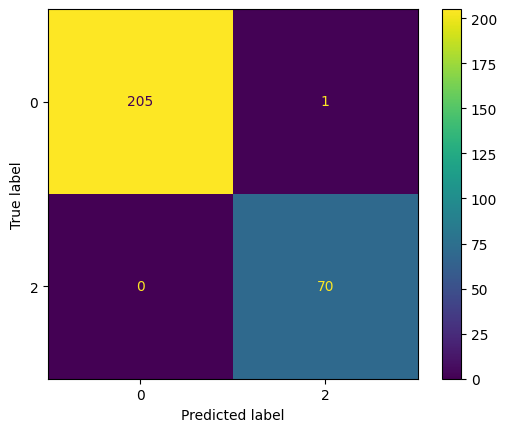

In [16]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_cMatrix, display_labels=CM_binary_model.classes_)
disp.plot()
plt.show()

    Method 2: Feature importance-based feature selection

In [93]:
#Feature importances for CM pair

CM_feat_importances = CM_binary_model.get_feature_importance(prettified=True)
CM_feat_importances.head(100)

,Feature Id,Importances
0,TATCG,8.235431
1,CCCCC,5.188696
2,ACGAA,3.212022
3,TCCAA,2.818384
4,CAGCC,2.275922
...,...,...
95,ACACA,0.185951
96,TGTCA,0.185870
97,ATGGT,0.181693
98,TCGTC,0.172550


In [94]:
# Show only feature importances above 0.1

threshold_chosen_features = CM_feat_importances[CM_feat_importances['Importances'] >= 0.1]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0.1 (selected features):", num_chosen_features)

    Feature Id  Importances
0        TATCG     8.235431
1        CCCCC     5.188696
2        ACGAA     3.212022
3        TCCAA     2.818384
4        CAGCC     2.275922
..         ...          ...
156      AAACG     0.102577
157      CGTTC     0.101997
158      CCTAG     0.101521
159      ACAGC     0.100986
160      CCGTA     0.100606

[161 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 161


In [95]:
print("Sum of total feature importances: ", sum(CM_feat_importances.Importances))
print("Sum of feature importances >=0.1: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  100.00000000000004
Sum of feature importances >=0.1:  84.01913486782402


In [96]:
# Select features with importance values above 0.1

CM_selected_feat = CM_feat_importances[:num_chosen_features]['Feature Id'].tolist()

print(CM_selected_feat)

['TATCG', 'CCCCC', 'ACGAA', 'TCCAA', 'CAGCC', 'TCGTT', 'CGGTA', 'TTACG', 'TCAGC', 'ATTGG', 'TCGAA', 'CGTTA', 'CTGAG', 'CCCAG', 'ACGTT', 'CAGCT', 'TTCGA', 'TGTAA', 'TTCGT', 'CTCAG', 'TCGAT', 'CCTGG', 'CAGCA', 'CCTCC', 'TGGTA', 'CGATT', 'CTCCT', 'CAGTC', 'GGCCT', 'GCCTG', 'CGAAA', 'CACCC', 'CGTTG', 'CCAGC', 'CACAG', 'TGTGT', 'GACGA', 'TACGG', 'TGACG', 'TTGCG', 'AGCCC', 'AGCAG', 'GACGT', 'TAACG', 'TGTGA', 'TATTG', 'GTCGT', 'GGTAT', 'TACGT', 'TTTCG', 'TACGA', 'CGATG', 'ACGCT', 'AACGA', 'CTATT', 'ACGAT', 'GGTAC', 'CGCGC', 'TATTC', 'TATGG', 'TTGGT', 'GCGCG', 'ATACG', 'CCAGG', 'CAATT', 'GGCAT', 'AGCCA', 'GCGAA', 'GTGTG', 'ATTAC', 'GCCCC', 'CCCCT', 'TGGTT', 'CTCCC', 'GGGGC', 'CCCGG', 'TTTTT', 'CAGTG', 'GCATC', 'CGATA', 'GACTA', 'CCGCG', 'TTGTA', 'ATCGG', 'CGTTT', 'AAACA', 'GTCCC', 'GCCAG', 'ATCCG', 'GCGGT', 'TCGAC', 'GGGAG', 'CGTAA', 'GTACG', 'ATCGA', 'ACACA', 'TGTCA', 'ATGGT', 'TCGTC', 'ATTCA', 'ATTGA', 'TATCA', 'CTGCA', 'TCCTG', 'GCTTG', 'CAATC', 'CGGAG', 'ATCAA', 'TCCGT', 'CTCTC', 'TTACT', 

In [97]:
CP_MT_X_train.shape

(1104, 1024)

In [98]:
# See original training set

CP_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


In [99]:
#Create training set with selected features 

CM_X_train_selected = CP_MT_X_train[CM_selected_feat]
CM_X_train_selected.head()

,TATCG,CCCCC,ACGAA,TCCAA,CAGCC,TCGTT,CGGTA,TTACG,TCAGC,ATTGG,...,TCAGA,GGTTA,AAGCC,GAGCC,GAACG,AAACG,CGTTC,CCTAG,ACAGC,CCGTA
0,0.000000,0.001267,0.000475,0.001584,0.000792,0.000317,0.000158,0.000158,0.001584,0.000950,...,0.001267,0.000158,0.002218,0.001267,0.000317,0.000792,0.000000,0.001267,0.002218,0.000158
1,0.000000,0.003205,0.000000,0.001166,0.004662,0.000291,0.000000,0.000000,0.001748,0.000583,...,0.001748,0.000291,0.001457,0.002040,0.000000,0.000000,0.000583,0.001166,0.001748,0.000000
2,0.000458,0.000458,0.000000,0.002750,0.001833,0.000458,0.000000,0.000000,0.001833,0.000458,...,0.002291,0.000458,0.000458,0.003208,0.000458,0.000458,0.000000,0.000917,0.002291,0.000000
3,0.000000,0.004948,0.000000,0.000990,0.003464,0.000000,0.000000,0.000000,0.000990,0.000000,...,0.001484,0.000000,0.000000,0.000495,0.000495,0.000000,0.000000,0.000990,0.001979,0.000495
4,0.000000,0.000622,0.000415,0.001037,0.001037,0.000104,0.000000,0.000207,0.001244,0.001244,...,0.001140,0.001140,0.000415,0.001037,0.000207,0.000415,0.000000,0.000207,0.001140,0.000104


In [100]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CM_X_train_selected.columns) == CM_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [101]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CM_X_train_selected.shape)
print("Shape of y_train (number of labels):", CP_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1104, 161)
Shape of y_train (number of labels): (1104,)


In [102]:
# Create pool object for selected feature data
print("Original number of features:", len(CM_feature_names), "\n Number of selected features:", len(CM_selected_feat))

CM_selected_train_pool = Pool(CM_X_train_selected, CP_MT_y_train, feature_names=CM_selected_feat)

Original number of features: 1024 
 Number of selected features: 161


In [103]:
#Create new model for data with selected features
CM_FIFS_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

CM_FIFS_model.fit(CM_selected_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6432384	total: 32.5ms	remaining: 32.5s
1:	learn: 0.5979846	total: 57.9ms	remaining: 28.9s
2:	learn: 0.5558290	total: 80.7ms	remaining: 26.8s
3:	learn: 0.5190900	total: 103ms	remaining: 25.6s
4:	learn: 0.4853278	total: 135ms	remaining: 26.9s
5:	learn: 0.4535323	total: 160ms	remaining: 26.5s
6:	learn: 0.4241804	total: 186ms	remaining: 26.4s
7:	learn: 0.3993251	total: 209ms	remaining: 25.9s
8:	learn: 0.3777839	total: 232ms	remaining: 25.5s
9:	learn: 0.3560515	total: 255ms	remaining: 25.3s
10:	learn: 0.3372200	total: 278ms	remaining: 25s
11:	learn: 0.3179266	total: 302ms	remaining: 24.8s
12:	learn: 0.3005055	total: 327ms	remaining: 24.8s
13:	learn: 0.2852431	total: 353ms	remaining: 24.8s
14:	learn: 0.2703303	total: 384ms	remaining: 25.2s
15:	learn: 0.2567358	total: 418ms	remaining: 25.7s
16:	learn: 0.2441232	total: 449ms	remaining: 26s
17:	learn: 0.2319205	total: 478ms	remaining: 26.1s
18:	learn: 0.2210285	total: 499ms	remaining: 25.8s
19:	learn: 0

In [104]:
#Check parameters used in this model fit

CM_FIFS_params = CM_FIFS_model.get_all_params()
print("Basic model parameters:", CM_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 2.942857027053833], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Multi

In [105]:
#Prediction using X_test only for selected features data
CM_FIFS_y_pred = CM_FIFS_model.predict(CP_MT_X_test)

#Predication probability for selected features data

CM_FIFS_y_prob = CM_FIFS_model.predict_proba(CP_MT_X_test)

In [106]:
# Calculate F1 score and get classification report

CM_FIFS_f1 = f1_score(CP_MT_y_test, CM_FIFS_y_pred, average='macro')
print(f"F1 Score: {CM_FIFS_f1}")

CM_FIFS_cr = classification_report(CP_MT_y_test, CM_FIFS_y_pred, digits=3)
print(CM_FIFS_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_FIFS_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_FIFS_y_prob))

F1 Score: 0.9951922239448151
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       206
           2      1.000     0.986     0.993        70

    accuracy                          0.996       276
   macro avg      0.998     0.993     0.995       276
weighted avg      0.996     0.996     0.996       276

Accuracy score:  0.9963768115942029


In [107]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_FIFS_y_pred.shape)

CM_FIFS_y_pred_fl = CM_FIFS_y_pred
print("flattened prediction values shape:", CM_FIFS_y_pred_fl.ravel().shape, "\n")

CM_FIFS_cMatrix = confusion_matrix(CP_MT_y_test, CM_FIFS_y_pred_fl)
print(CM_FIFS_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[206   0]
 [  1  69]]


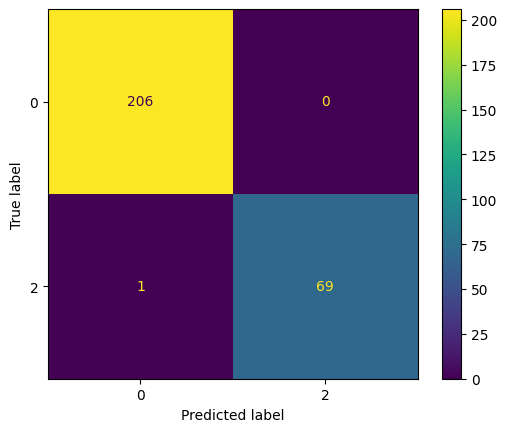

In [108]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_FIFS_cMatrix, display_labels=CM_FIFS_model.classes_)
disp.plot()
plt.show()

    Method 7: Modelling using feature selection based on feature importance values (with get_feature_importances type = "ShapValues"), w/ threshold > 0 & class imbalance accounted for 

In [17]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(CM_binary_model)

In [18]:
#SHAP values for X_train
CM_shap_values = explainer.shap_values(CP_MT_X_train)

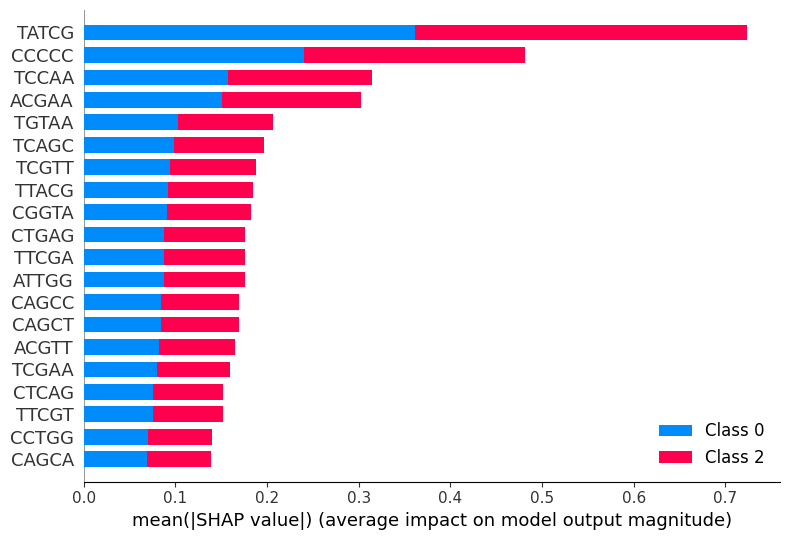

In [52]:
shap.summary_plot(CM_shap_values, CP_MT_X_train, plot_size=0.2, class_names=["Class 0", "Class 2"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


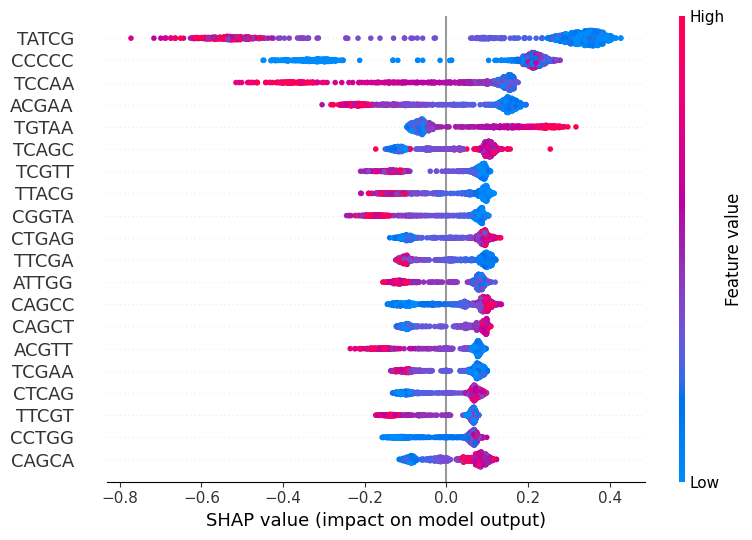

In [20]:
shap.summary_plot(CM_shap_values[0], CP_MT_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


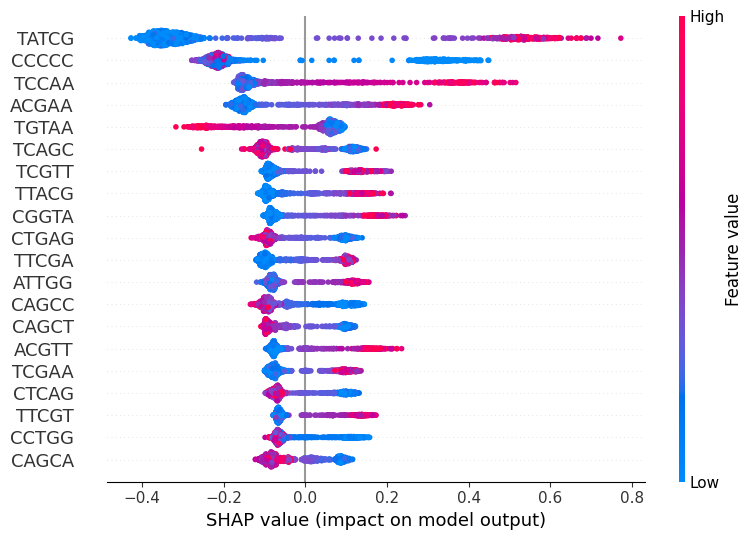

In [21]:
shap.summary_plot(CM_shap_values[1], CP_MT_X_train, plot_size=0.2)

In [22]:
shap_df = pd.DataFrame(CM_shap_values[0], columns=CP_MT_X_train.columns)


In [23]:
CM_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [24]:
CM_shap_FI.head(100)

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,TATCG,0.322083
1,CCCCC,0.213698
2,TGTAA,0.184971
3,ACGAA,0.145795
4,TCCAA,0.130736
...,...,...
95,CCCCT,0.015787
96,TATCA,0.015585
97,GGACA,0.015565
98,CGTAA,0.015526


In [25]:
# shap.summary_plot(CM_shap_values[0], CP_MT_X_train, show=False, max_display=30, plot_size=0.2)

In [26]:
# #Try####

# vals= np.abs(CM_shap_values).mean(0)

# newtry_feature_importance = pd.DataFrame(list(zip(CP_MT_X_train.columns, sum(vals))), columns=['col_name','feature_importanCM_vals'])
# newtry_feature_importance.sort_values(by=['feature_importanCM_vals'], ascending=False,inplace=True)
# newtry_feature_importance

In [27]:
# newtry_feature_importance.head(10)

In [120]:
#Classifier results with CM_feature_importance

In [28]:
# Show only feature importances above 0

CM_SHAP_thres_chosen = CM_shap_FI[CM_shap_FI['Importances'] > 0]
CM_shap_num_chosen = len(CM_SHAP_thres_chosen)

print(CM_SHAP_thres_chosen)

print("\nAmount of features with importnace above 0 (selected features):", CM_shap_num_chosen)

    Feature Id  Importances
0        TATCG     0.322083
1        CCCCC     0.213698
2        TGTAA     0.184971
3        ACGAA     0.145795
4        TCCAA     0.130736
..         ...          ...
771      GAGAC     0.000023
772      AACCT     0.000015
773      CCGGA     0.000008
774      ACATA     0.000006
775      GACCG     0.000004

[776 rows x 2 columns]

Amount of features with importnace above 0 (selected features): 776


In [29]:
print("Sum of total feature importances: ", sum(CM_shap_FI.Importances))
print("Sum of feature importances >0: ", sum(CM_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances >0:  6.930605005504988


In [31]:
# Select features with importance values above 0.1

CM_shap_selected_feat = CM_shap_FI[:CM_shap_num_chosen]['Feature Id'].tolist()

# print(CM_shap_selected_feat)

In [32]:
CP_MT_X_train.shape

(1104, 1024)

In [33]:
# See original training set

CP_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


In [34]:
#Create training set with selected features 

CM_X_train_shap_selected = CP_MT_X_train[CM_shap_selected_feat]
CM_X_train_shap_selected.head()

,TATCG,CCCCC,TGTAA,ACGAA,TCCAA,TCAGC,TTACG,TTCGA,CTGAG,CAGCC,...,ACTCT,AATTA,CCCAT,TTTAG,AATAG,GAGAC,AACCT,CCGGA,ACATA,GACCG
0,0.000000,0.001267,0.001426,0.000475,0.001584,0.001584,0.000158,0.000317,0.001267,0.000792,...,0.000950,0.001426,0.001109,0.001109,0.000792,0.000950,0.000792,0.000317,0.001901,0.000475
1,0.000000,0.003205,0.000291,0.000000,0.001166,0.001748,0.000000,0.001166,0.003205,0.004662,...,0.000291,0.000000,0.002622,0.000000,0.000000,0.001166,0.000291,0.002331,0.000000,0.001457
2,0.000458,0.000458,0.000000,0.000000,0.002750,0.001833,0.000000,0.000917,0.001375,0.001833,...,0.000458,0.000000,0.001833,0.001833,0.000000,0.001833,0.000458,0.001833,0.000000,0.000000
3,0.000000,0.004948,0.000000,0.000000,0.000990,0.000990,0.000000,0.000990,0.002969,0.003464,...,0.000990,0.000495,0.000000,0.000000,0.000495,0.000495,0.000990,0.000990,0.000495,0.000990
4,0.000000,0.000622,0.001451,0.000415,0.001037,0.001244,0.000207,0.000415,0.001762,0.001037,...,0.000726,0.001659,0.000933,0.001555,0.001244,0.000933,0.001244,0.000311,0.001140,0.000104


In [35]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CM_X_train_shap_selected.columns) == CM_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [36]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CM_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", CP_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1104, 776)
Shape of y_train (number of labels): (1104,)


In [37]:
# Create pool object for selected feature data
print("Original number of features:", len(CM_feature_names), "\n Number of selected features:", len(CM_shap_selected_feat))

CM_shap_selected_train_pool = Pool(CM_X_train_shap_selected, CP_MT_y_train, feature_names=CM_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 776


In [38]:
#Create new model for data with selected features
CM_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

CM_FIFS_shap_model.fit(CM_shap_selected_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6461011	total: 208ms	remaining: 3m 28s
1:	learn: 0.6035327	total: 308ms	remaining: 2m 33s
2:	learn: 0.5627360	total: 406ms	remaining: 2m 14s
3:	learn: 0.5237146	total: 512ms	remaining: 2m 7s
4:	learn: 0.4904903	total: 615ms	remaining: 2m 2s
5:	learn: 0.4626455	total: 734ms	remaining: 2m 1s
6:	learn: 0.4387029	total: 845ms	remaining: 1m 59s
7:	learn: 0.4134149	total: 974ms	remaining: 2m
8:	learn: 0.3908821	total: 1.09s	remaining: 1m 59s
9:	learn: 0.3691758	total: 1.21s	remaining: 2m
10:	learn: 0.3501161	total: 1.32s	remaining: 1m 58s
11:	learn: 0.3322522	total: 1.41s	remaining: 1m 56s
12:	learn: 0.3162043	total: 1.53s	remaining: 1m 55s
13:	learn: 0.3010862	total: 1.64s	remaining: 1m 55s
14:	learn: 0.2869099	total: 1.73s	remaining: 1m 53s
15:	learn: 0.2733594	total: 1.84s	remaining: 1m 53s
16:	learn: 0.2592092	total: 1.93s	remaining: 1m 51s
17:	learn: 0.2474763	total: 2.03s	remaining: 1m 50s
18:	learn: 0.2349212	total: 2.13s	remaining: 1m 49s
19:

In [39]:
#Check parameters used in this model fit

CM_FIFS_shap_params = CM_FIFS_shap_model.get_all_params()
print("Basic model parameters:", CM_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 2.942857027053833], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Multi

In [40]:
#Prediction using X_test only for selected features data
CM_FIFS_shap_y_pred = CM_FIFS_shap_model.predict(CP_MT_X_test)

#Predication probability for selected features data

CM_FIFS_shap_y_prob = CM_FIFS_shap_model.predict_proba(CP_MT_X_test)

In [49]:
# Calculate F1 score and get classification report

print("Model 7: Feature selection (SHAP) w/ threshold > 0 and class imbalance accounted for - \n\t\t\t\t\tCytoplasm & mitochondria")

print("\nNumber of chosen features:", len(CM_shap_selected_feat), "\n")

CM_FIFS_shap_cr = classification_report(CP_MT_y_test, CM_FIFS_shap_y_pred, digits=3)
print(CM_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_FIFS_shap_y_pred))


CM_FIFS_shap_f1 = f1_score(CP_MT_y_test, CM_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {CM_FIFS_shap_f1}")

# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_FIFS_shap_y_prob))

Model 7: Feature selection (SHAP) w/ threshold > 0 and class imbalance accounted for - 
					Cytoplasm & mitochondria

Number of chosen features: 776 

              precision    recall  f1-score   support

           0      0.995     1.000     0.998       206
           2      1.000     0.986     0.993        70

    accuracy                          0.996       276
   macro avg      0.998     0.993     0.995       276
weighted avg      0.996     0.996     0.996       276

Accuracy score:  0.9963768115942029

F1 Score: 0.9951922239448151


In [50]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_FIFS_shap_y_pred.shape)

CM_FIFS_shap_y_pred_fl = CM_FIFS_shap_y_pred
print("flattened prediction values shape:", CM_FIFS_shap_y_pred_fl.ravel().shape, "\n")

CM_FIFS_shap_cMatrix = confusion_matrix(CP_MT_y_test, CM_FIFS_shap_y_pred_fl)
print(CM_FIFS_shap_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[206   0]
 [  1  69]]


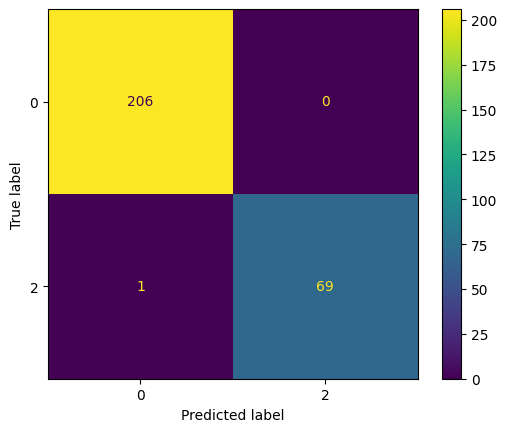

In [51]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_FIFS_shap_cMatrix, display_labels=CM_FIFS_shap_model.classes_)
disp.plot()
plt.show()

In [136]:
#Classifier results with newtry_feature_importance

In [137]:
newtry_feature_importance.head(100)

,col_name,feature_importanCM_vals
822,TATCG,399.332902
341,CCCCC,265.487886
848,TCCAA,173.391889
96,ACGAA,167.024383
944,TGTAA,114.247623
...,...,...
418,CGGAG,17.139667
484,CTGCA,17.067861
681,GGGGC,16.353260
862,TCCTG,16.338379


In [138]:
# Show only feature importances above 0.1

CM_newSHAP_thres_chosen = newtry_feature_importance[:100]
CM_newshap_num_chosen = len(CM_newSHAP_thres_chosen)

print(CM_newSHAP_thres_chosen)

print("\nAmount of features with importnace above 0.1 (selected features):", CM_newshap_num_chosen)

    col_name  feature_importanCM_vals
822    TATCG               399.332902
341    CCCCC               265.487886
848    TCCAA               173.391889
96     ACGAA               167.024383
944    TGTAA               114.247623
..       ...                      ...
418    CGGAG                17.139667
484    CTGCA                17.067861
681    GGGGC                16.353260
862    TCCTG                16.338379
317    CATTC                16.294542

[100 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 100


In [139]:
print("Sum of total feature importances: ", sum(newtry_feature_importance.feature_importanCM_vals))
print("Sum of feature importances >=0.1: ", sum(CM_newSHAP_thres_chosen.feature_importanCM_vals))

Sum of total feature importances:  7455.76200616163
Sum of feature importances >=0.1:  5126.449178604996


In [140]:
# Select features with importance values above 0.1

CM_newshap_selected_feat = newtry_feature_importance[:CM_newshap_num_chosen]['col_name'].tolist()

print(CM_newshap_selected_feat)

['TATCG', 'CCCCC', 'TCCAA', 'ACGAA', 'TGTAA', 'TCAGC', 'TCGTT', 'TTACG', 'CGGTA', 'CTGAG', 'TTCGA', 'ATTGG', 'CAGCC', 'CAGCT', 'ACGTT', 'TCGAA', 'CTCAG', 'TTCGT', 'CCTGG', 'CAGCA', 'CGTTA', 'CAGTC', 'GACGA', 'CCCAG', 'CTCCT', 'CCTCC', 'CACCC', 'GGCCT', 'GCCTG', 'TCGAT', 'CGTTG', 'CACAG', 'TGTGT', 'CGAAA', 'CGATT', 'TGACG', 'GGTAC', 'TGGTA', 'GACGT', 'CCAGC', 'AGCCC', 'TGTGA', 'AGCAG', 'GCGCG', 'TACGG', 'TATTG', 'AAAAA', 'CCAGG', 'CTATT', 'TTTCG', 'TTGCG', 'TATGG', 'ACGAT', 'CTCCC', 'GTCGT', 'TAACG', 'ACGCT', 'ACACA', 'GCCCC', 'TTGGT', 'GCGGT', 'ATTAC', 'CGCGC', 'TACGT', 'GGTAT', 'GCGAA', 'CAGTG', 'GTGTG', 'CGAAG', 'CGATG', 'GGCAT', 'TACGA', 'ATCAA', 'ATCCG', 'ATACG', 'CCCCT', 'AACGA', 'CGATA', 'GGGGA', 'CGTAA', 'ATCGG', 'AGCCA', 'TCAAA', 'TTACT', 'GACCT', 'GGGAG', 'CGTTT', 'ATGGT', 'CAATT', 'ATTCA', 'TGGTT', 'TATTC', 'CCCCG', 'GGTAA', 'AAGAT', 'CGGAG', 'CTGCA', 'GGGGC', 'TCCTG', 'CATTC']


In [141]:
CP_MT_X_train.shape

(1104, 1024)

In [142]:
# See original training set

CP_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


In [143]:
#Create training set with selected features 

CM_X_train_newshap_selected = CP_MT_X_train[CM_newshap_selected_feat]
CM_X_train_newshap_selected.head()

,TATCG,CCCCC,TCCAA,ACGAA,TGTAA,TCAGC,TCGTT,TTACG,CGGTA,CTGAG,...,TGGTT,TATTC,CCCCG,GGTAA,AAGAT,CGGAG,CTGCA,GGGGC,TCCTG,CATTC
0,0.000000,0.001267,0.001584,0.000475,0.001426,0.001584,0.000317,0.000158,0.000158,0.001267,...,0.001109,0.000950,0.001901,0.000950,0.001267,0.001267,0.002059,0.000475,0.000950,0.001109
1,0.000000,0.003205,0.001166,0.000000,0.000291,0.001748,0.000291,0.000000,0.000000,0.003205,...,0.001166,0.000000,0.002040,0.000000,0.000000,0.002622,0.001457,0.004371,0.003205,0.000583
2,0.000458,0.000458,0.002750,0.000000,0.000000,0.001833,0.000458,0.000000,0.000000,0.001375,...,0.000917,0.000917,0.001833,0.000458,0.001375,0.001833,0.001833,0.003208,0.001375,0.000917
3,0.000000,0.004948,0.000990,0.000000,0.000000,0.000990,0.000000,0.000000,0.000000,0.002969,...,0.000495,0.000000,0.001484,0.000000,0.000495,0.001979,0.001979,0.005938,0.003464,0.000000
4,0.000000,0.000622,0.001037,0.000415,0.001451,0.001244,0.000104,0.000207,0.000000,0.001762,...,0.001244,0.001348,0.000207,0.000726,0.001451,0.000311,0.001451,0.000207,0.001140,0.001140


In [144]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CM_X_train_newshap_selected.columns) == CM_newshap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [145]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CM_X_train_newshap_selected.shape)
print("Shape of y_train (number of labels):", CP_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1104, 100)
Shape of y_train (number of labels): (1104,)


In [146]:
# Create pool object for selected feature data
print("Original number of features:", len(CM_feature_names), "\n Number of selected features:", len(CM_newshap_selected_feat))

CM_newshap_selected_train_pool = Pool(CM_X_train_newshap_selected, CP_MT_y_train, feature_names=CM_newshap_selected_feat)

Original number of features: 1024 
 Number of selected features: 100


In [147]:
#Create new model for data with selected features
CM_FIFS_newshap_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

CM_FIFS_newshap_model.fit(CM_newshap_selected_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6443421	total: 18.3ms	remaining: 18.2s
1:	learn: 0.5967221	total: 29.9ms	remaining: 14.9s
2:	learn: 0.5553662	total: 41.5ms	remaining: 13.8s
3:	learn: 0.5191078	total: 53.2ms	remaining: 13.2s
4:	learn: 0.4847784	total: 65.1ms	remaining: 13s
5:	learn: 0.4530909	total: 76.9ms	remaining: 12.7s
6:	learn: 0.4229425	total: 89.5ms	remaining: 12.7s
7:	learn: 0.3985392	total: 103ms	remaining: 12.8s
8:	learn: 0.3748878	total: 117ms	remaining: 12.9s
9:	learn: 0.3526626	total: 131ms	remaining: 12.9s
10:	learn: 0.3322847	total: 143ms	remaining: 12.9s
11:	learn: 0.3137268	total: 156ms	remaining: 12.8s
12:	learn: 0.2965319	total: 168ms	remaining: 12.8s
13:	learn: 0.2837215	total: 181ms	remaining: 12.8s
14:	learn: 0.2679428	total: 193ms	remaining: 12.7s
15:	learn: 0.2552807	total: 206ms	remaining: 12.7s
16:	learn: 0.2430999	total: 218ms	remaining: 12.6s
17:	learn: 0.2311894	total: 230ms	remaining: 12.5s
18:	learn: 0.2212192	total: 242ms	remaining: 12.5s
19:	le

In [148]:
#Check parameters used in this model fit

CM_FIFS_newshap_params = CM_FIFS_newshap_model.get_all_params()
print("Basic model parameters:", CM_FIFS_newshap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 2.942857027053833], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Multi

In [149]:
#Prediction using X_test only for selected features data
CM_FIFS_newshap_y_pred = CM_FIFS_newshap_model.predict(CP_MT_X_test)

#Predication probability for selected features data

CM_FIFS_newshap_y_prob = CM_FIFS_newshap_model.predict_proba(CP_MT_X_test)

In [150]:
# Calculate F1 score and get classification report

CM_FIFS_newshap_f1 = f1_score(CP_MT_y_test, CM_FIFS_newshap_y_pred, average='macro')
print(f"F1 Score: {CM_FIFS_newshap_f1}")

CM_FIFS_newshap_cr = classification_report(CP_MT_y_test, CM_FIFS_newshap_y_pred, digits=3)
print(CM_FIFS_newshap_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_FIFS_newshap_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_FIFS_newshap_y_prob))

F1 Score: 0.9904299583911235
              precision    recall  f1-score   support

           0      0.995     0.995     0.995       206
           2      0.986     0.986     0.986        70

    accuracy                          0.993       276
   macro avg      0.990     0.990     0.990       276
weighted avg      0.993     0.993     0.993       276

Accuracy score:  0.9927536231884058


In [151]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_FIFS_newshap_y_pred.shape)

CM_FIFS_newshap_y_pred_fl = CM_FIFS_newshap_y_pred
print("flattened prediction values shape:", CM_FIFS_newshap_y_pred_fl.ravel().shape, "\n")

CM_FIFS_newshap_cMatrix = confusion_matrix(CP_MT_y_test, CM_FIFS_newshap_y_pred_fl)
print(CM_FIFS_newshap_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[205   1]
 [  1  69]]


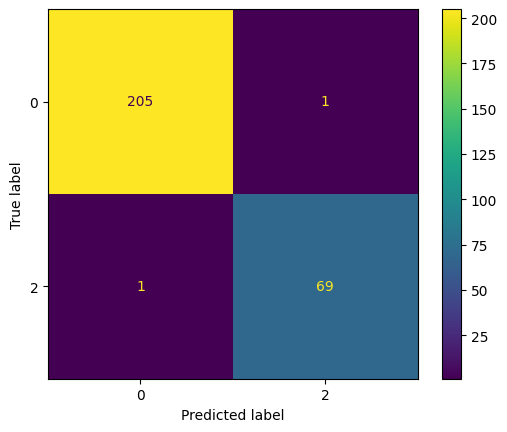

In [152]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_FIFS_newshap_cMatrix, display_labels=CM_FIFS_newshap_model.classes_)
disp.plot()
plt.show()